In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
%matplotlib inline

In [2]:
#Ignore harmless warnings from statsmodel
import warnings
warnings.filterwarnings("ignore")

In [5]:
os.getcwd()
os.chdir('/Users/Jeffrey.Lu@ibm.com/Desktop')

In [6]:
df = pd.read_csv("Pricing_Forecast_File .csv", index_col = 'date', parse_dates = True)

In [7]:
#CSV file manipulation
df.index.freq = 'D'

In [8]:
df1 = df.loc[df.eCPM.notnull()]

In [9]:
df1.eCPM = df1.eCPM.str.replace('$',"")

In [10]:
df1['eCPM'] = df1.eCPM.astype('float')

In [12]:
#Testing for stationarity via dickey-fuller test
adfuller(df1['eCPM'], autolag = 'AIC')

(-4.329599686615713,
 0.0003946071384632504,
 3,
 486,
 {'1%': -3.4438771098680196,
  '5%': -2.867505393939065,
  '10%': -2.569947324764179},
 2023.843588164737)

In [13]:
#Creating Function that formats and interprets test results
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
#Implementing formatted dickey-fuller test: Stationarity will show that forecasts should not show strong trendline we don't need to implement an "I"-related model ie. ARIMA/SARIMA

adf_test(df1['eCPM'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.329600
p-value                   0.000395
# lags used               3.000000
# observations          486.000000
critical value (1%)      -3.443877
critical value (5%)      -2.867505
critical value (10%)     -2.569947
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


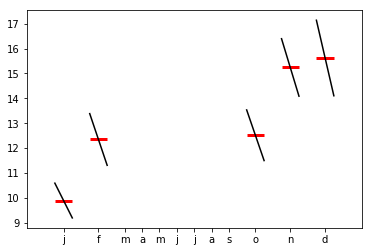

In [15]:
#Analzing monthly seasonality; Time Series resampling Day to Month Needed

dfm = df1.resample(rule = 'MS').mean()

#Month-Plot

month_plot(dfm['eCPM']);


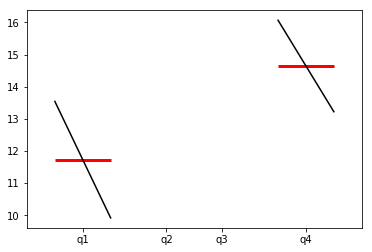

In [16]:
#Analzing quarterly seasonality; Time Series resampling Day to Quarter Needed

dfq = df1.resample(rule = 'Q').mean()

#Quarter-Plots

quarter_plot(dfq['eCPM']);

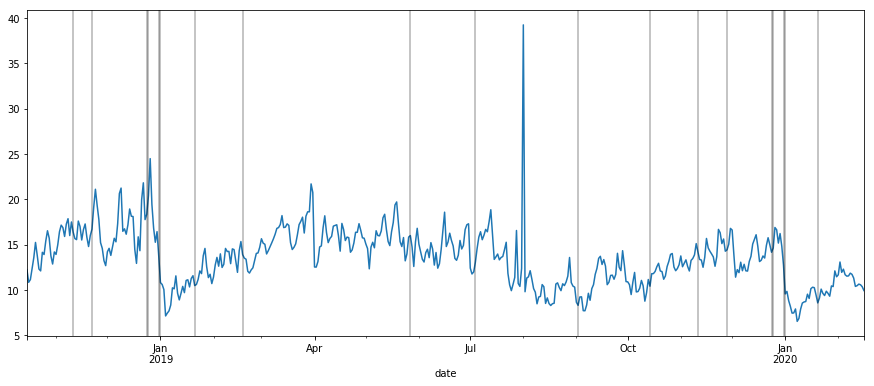

In [17]:
#Plotting Prices over time and adding vertical marker lines for Holidays
ax = df1['eCPM'].plot(figsize = (15,6))

for day in df1.query('holiday==1').index:
    ax.axvline(x=day, color='black', alpha = 0.3);

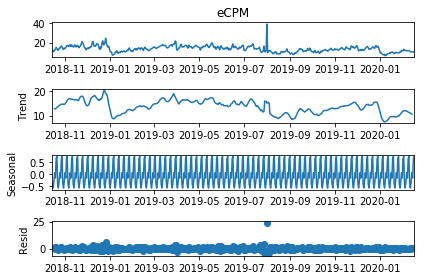

In [18]:
#Creating ETS Decomposition Plots

result = seasonal_decompose(df1['eCPM'])
result.plot();

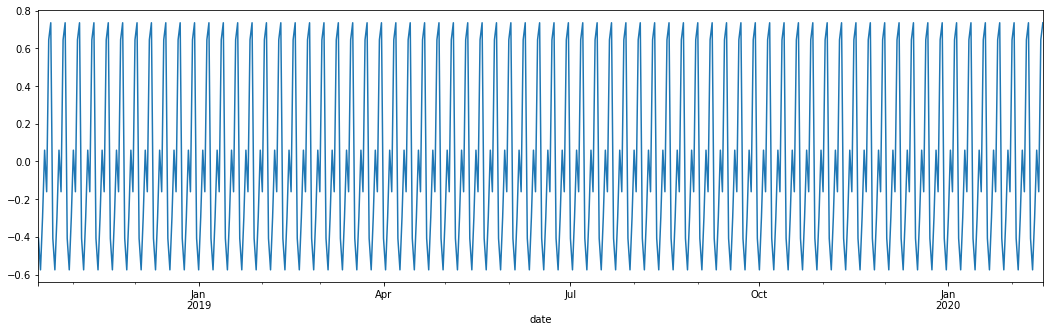

In [19]:
#Zooming into the Seasonal component of ETS

result.seasonal.plot(figsize=(18,5))

In [20]:
#Figuring out Train/Test Split lengths

len(df1)

490

In [21]:
#There are 135 days of data we wish to forecast so we will need at least 135 days worth of data in the test set
train = df1.iloc[:355]
test = df1.iloc[355:]

In [46]:
#Finding SARIMA Model Parameters

auto_arima(df1['eCPM'],seasonal = True, m = 4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  490
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 4)   Log Likelihood               -1040.814
Date:                           Fri, 06 Mar 2020   AIC                           2091.628
Time:                                   16:59:48   BIC                           2112.590
Sample:                                        0   HQIC                          2099.861
                                           - 490                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0028      0.015     -0.183      0.855      -0.033       0.027
ar.L1          0.4613      0.031     14.993      0.000       0.401       0.522
ma.L1         -0.8927      0.036    -24.803      0.000      -0.963      -0.822
ma.S.L4        0.1597      0.031      5.216      0.000       0.100       0.220
sigma2         4.1273      0.096     43.136      0.000       3.940       4.315
===================================================================================
Ljung-Box (Q):                       28.00   Jarque-Bera (JB):             82676.61
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             2.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        66.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
#Fitting SARIMA Model

model = SARIMAX(train['eCPM'], order = (1,1,1), seasonal_order = (0,0,1,4), enforce_invertibility = False)

In [48]:
results = model.fit()

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              eCPM   No. Observations:                  355
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 4)   Log Likelihood                -794.506
Date:                           Fri, 06 Mar 2020   AIC                           1597.012
Time:                                   17:01:24   BIC                           1612.489
Sample:                               10-15-2018   HQIC                          1603.170
                                    - 10-04-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4171      0.032     13.000      0.000       0.354       0.480
ma.L1         -0.8981      0.040    -22.371      0.000      -0.977      -0.819
ma.S.L4        0.1626      0.037      4.406      0.000       0.090       0.235
sigma2         5.1995      0.147     35.463      0.000       4.912       5.487
===================================================================================
Ljung-Box (Q):                       18.60   Jarque-Bera (JB):             40273.13
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             3.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
#Extracting and plotting predicted values into the future for our test set

start = len(train)
end = len(train) + len(test) - 1

In [51]:
predictions = results.predict(start, end).rename('SARIMA model')

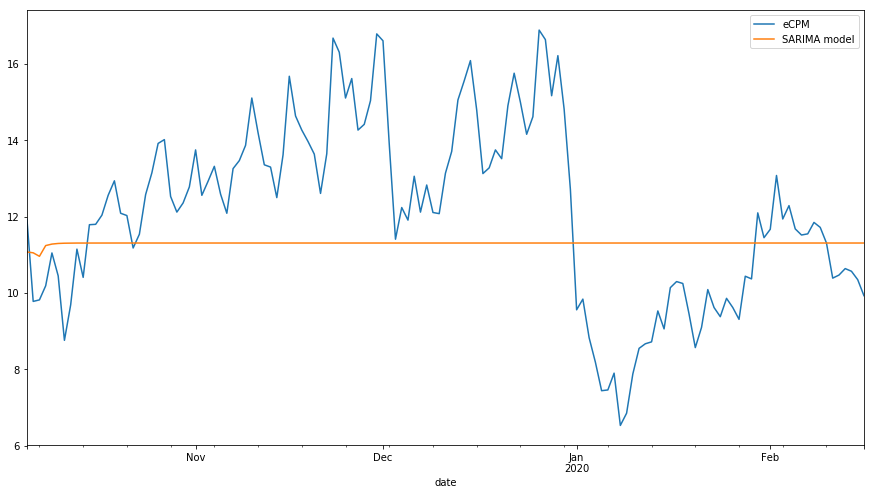

In [52]:
test['eCPM'].plot(legend = True, figsize = (15,8))
predictions.plot(legend = True)

In [53]:
#Evaluation RMSE of SARIMA Model
rmse(test['eCPM'],predictions)

2.487491493062102

In [54]:
test['eCPM'].mean()

12.152148148148143

In [55]:
rmse(test['eCPM'],predictions)/test['eCPM'].mean()

0.20469561946882364

In [56]:
#Adding in Exogenous variables to create SARIMAX model

auto_arima(df1['eCPM'], exogenous = df1[['holiday']], seasonal = 'True', m = 4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  490
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 4)   Log Likelihood               -1040.112
Date:                           Fri, 06 Mar 2020   AIC                           2092.224
Time:                                   17:01:57   BIC                           2117.378
Sample:                               10-15-2018   HQIC                          2102.104
                                    - 02-16-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0028      0.015     -0.183      0.855      -0.033       0.027
holiday       -0.5181      0.623     -0.832      0.406      -1.739       0.703
ar.L1          0.4657      0.031     15.226      0.000       0.406       0.526
ma.L1         -0.8936      0.036    -24.915      0.000      -0.964      -0.823
ma.S.L4        0.1613      0.030      5.310      0.000       0.102       0.221
sigma2         4.1153      0.095     43.292      0.000       3.929       4.302
===================================================================================
Ljung-Box (Q):                       27.37   Jarque-Bera (JB):             83918.78
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        66.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
#Train Model

model = SARIMAX(train['eCPM'], exog = train[['holiday']], order = (1,1,1), seasonal_order = (0,0,1,4), enforce_invertibility = False)

In [64]:
result = model.fit()

In [65]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              eCPM   No. Observations:                  355
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 4)   Log Likelihood                -794.333
Date:                           Fri, 06 Mar 2020   AIC                           1598.665
Time:                                   17:02:38   BIC                           1618.012
Sample:                               10-15-2018   HQIC                          1606.363
                                    - 10-04-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       -0.3801      0.891     -0.427      0.670      -2.126       1.365
ar.L1          0.4193      0.032     13.097      0.000       0.357       0.482
ma.L1         -0.8985      0.040    -22.395      0.000      -0.977      -0.820
ma.S.L4        0.1629      0.037      4.415      0.000       0.091       0.235
sigma2         5.1945      0.146     35.507      0.000       4.908       5.481
===================================================================================
Ljung-Box (Q):                       18.39   Jarque-Bera (JB):             40509.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.05   Skew:                             3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [521]:
#Extracting and plotting predicted values into the future for our test set
start = len(train)
end = len(train) + len(test) - 1

In [522]:
predictions = result.predict(start, end, exog = test[['holiday']]).rename('SARIMAX with Exog')

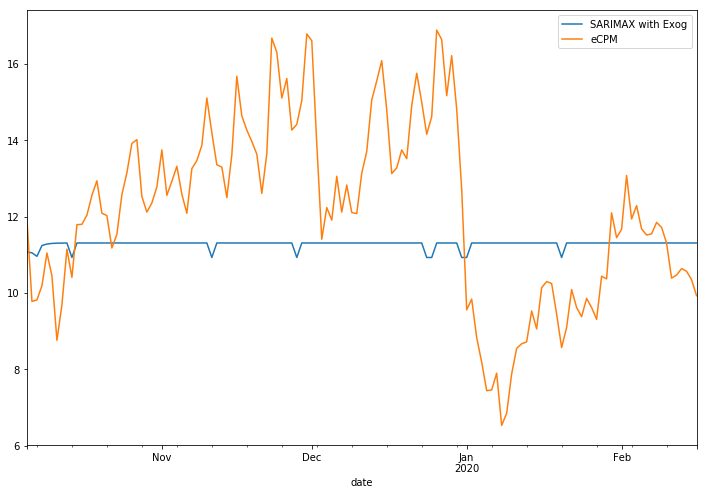

In [523]:
predictions.plot(figsize=(12,8), legend = True)
test['eCPM'].plot(legend = True)


In [524]:
rmse(test['eCPM'],predictions)

2.498042956221521

In [525]:
test['eCPM'].mean()

12.152148148148143

In [526]:
rmse(test['eCPM'],predictions)/test['eCPM'].mean()

0.20556389913681195

In [550]:
#Decide to go with SARIMAX Model due to lower rmse value; Train model on entire data set

model = SARIMAX(df1['eCPM'], exog = df1[['holiday']], order = (3,1,2), seasonal_order = (1,0,[],12), enforece_invertibility = False)

In [551]:
results = model.fit()

In [552]:
#Grabbing future exogenous values (holiday) dates
exog_forecast = df.iloc[491:625][['holiday']]

In [553]:
fcast = results.predict(len(df1),len(df1)+133, exog = exog_forecast).rename('Final SARIMAX Forecast')

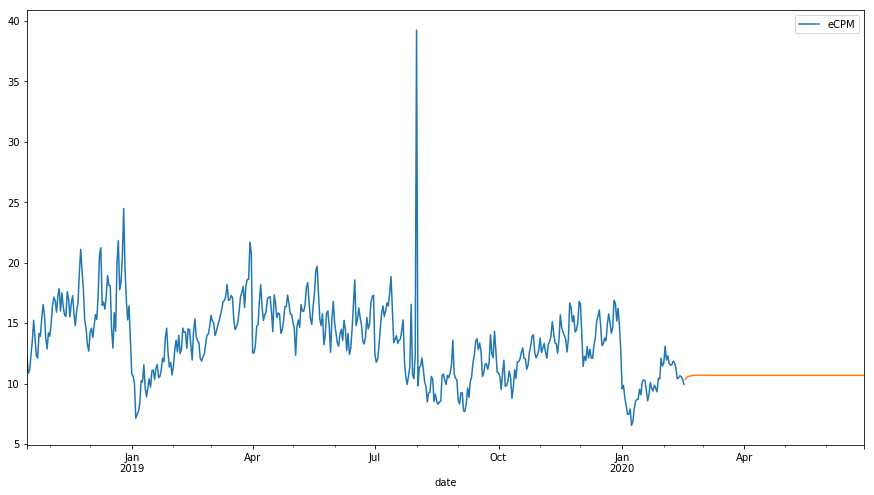

In [554]:
df1['eCPM'].plot(figsize = (15,8), legend = True)
fcast.plot()

In [555]:
#Utilizing Fourier terms to improve seasonality forecasts.
exog = df1
exog['sin365'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['holiday_name','holiday','weekday','eCPM'])
exog_to_train = exog.iloc[:355]
exog_to_test = exog.iloc[355:]

In [556]:
#SARIMAX Model with additional Seasonality Adjustment made with 2 Fourier terms

In [557]:
arima_exog_model = auto_arima(y=df1['eCPM'].iloc[:355], exogenous=exog_to_train, seasonal=True, m=7)

In [558]:
#Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=135, exogenous=exog_to_test)

In [559]:
df4 = df1.reset_index()

In [560]:
df4 = df4.date.iloc[355:]

In [561]:
df5 = pd.Series(df4)

In [562]:
df_arima = pd.DataFrame(y_arima_exog_forecast)

In [563]:
list1 = []
for i in df5:
    list1.append(pd.to_datetime(i))

In [564]:
df_arima['date'] = list1

In [565]:
df_arima.set_index('date', inplace = True)

In [566]:
df_arima.columns = ['eCPM']

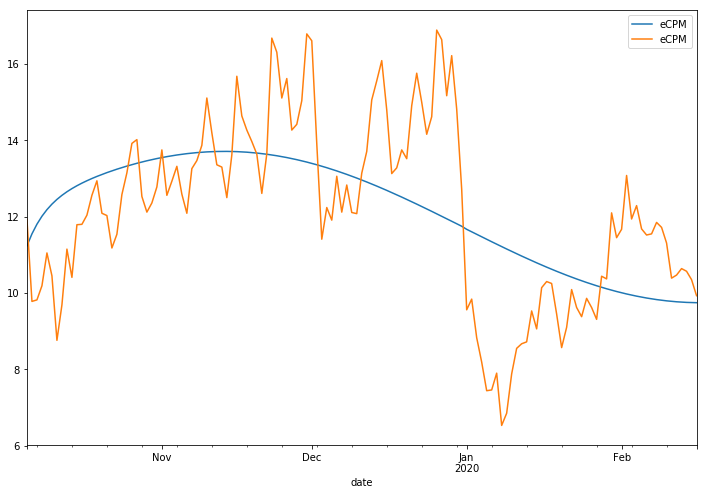

In [567]:
df_arima.plot(figsize=(12,8), legend = True)
test['eCPM'].plot(legend = True)


In [ ]:
#Model Evaluation

In [ ]:
rmse(test['eCPM'],df_arima['eCPM'])

In [ ]:
test['eCPM'].mean()

In [ ]:
rmse(test['eCPM'],df_arima['eCPM'])/test['eCPM'].mean()

In [ ]:
#Training the model on the entire dataset: utilizing Fourier terms to improve seasonality forecasts
exog = df1
exog['sin365'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['holiday_name','holiday','weekday','eCPM'])

In [531]:
arima_exog_model2 = auto_arima(y=df1['eCPM'], exogenous=exog, seasonal=True, m=7)

In [532]:
results = arima_exog_model2.fit(df1['eCPM'])

In [533]:
fcast = results.predict(n_periods = 100000, exogenous = exog_forecast)

In [534]:
fcast = pd.DataFrame(list(fcast))

In [535]:
df_future_dates = pd.DataFrame(pd.Series(list(df[490:].index)))

In [536]:
df_future_dates.rename(columns={0:'Date'}, inplace = True)

In [537]:
fcast.rename(columns={0:'eCPM'}, inplace = True)

In [538]:
fcast['Date'] = df_future_dates

In [539]:
fcast.set_index('Date', inplace = True)

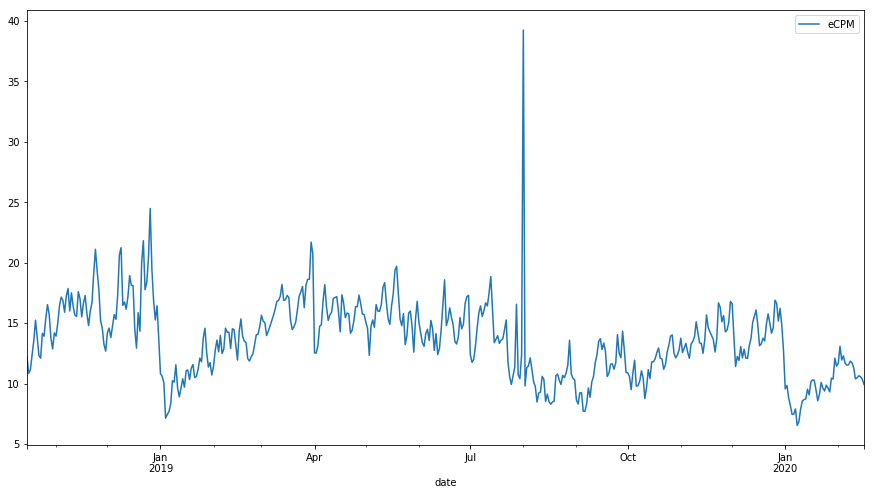

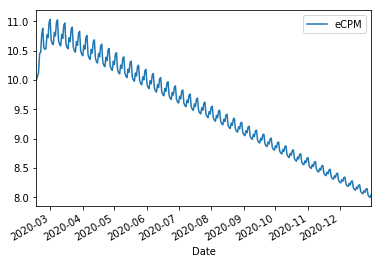

In [540]:
df1['eCPM'].plot(figsize = (15,8), legend = True)
fcast.plot()